# Schrodinger's Equation

## References -- move to bottom
* Atkins & Friedman (Molecular Quantum Mechanics textbook)
* Barba, Lorena A., et al. "MAE 6286 Practical Numerical Methods with Python." The George Washington University. http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about. 2014
* http://arxiv.org/pdf/0704.3240.pdf

Wave functions are used in quantum mechanics to describe the position of a particle at a certain time. The fundamental equation used to solve these wave functions is the Schrodinger equation. 

\begin{equation}
i\hbar\frac{\partial}{\partial t}\psi(x, t) = -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2}\psi(x, t)
\end{equation}

Discretized Equation:

\begin{eqnarray}
i\hbar\frac{\psi^{n+1}_i - \psi^n_i}{\Delta t} = \frac{\hbar^2}{2m} \cdot \frac{1}{2} &\left( 
\frac{\psi^{n+1}_{i+1} - 2\psi^{n+1}_i + \psi^{n+1}_{i-1}}{\Delta x^2} 
+ \frac{\psi^n_{i+1}-2\psi^n_i + \psi^n_{i-1}}{\Delta x^2}
\right)
\end{eqnarray}

In [62]:
import numpy
from scipy.linalg import solve
from scipy.interpolate import spline
from matplotlib import pyplot
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [72]:
L = 1
nx = 51 #21

h = 6.62607004e-34 #[m^2*kg/s]
hbar = h/(2*numpy.pi)
#hbar=1
m = 6.6464764063e-27 #[kg] - mass of Helium ion
dx = L/(nx-1)


psi_i = numpy.zeros(nx, dtype = numpy.complex)
psi_i[0] = 1

sigma = 0.5 #0.5
dt = sigma*(dx**2)*m/hbar
#dt=1e-5

nt = 10

In [73]:
def generateMatrix(N, sigma):
   
    ##We need a TRIDIAGONAL MATRIX!!

    # Set Diagonalfrom discritization
    d = numpy.diag(numpy.ones(N-2)*(1+2j/sigma))
       
    # Set Upper Diagonal
    ud = numpy.diag(numpy.ones(N-3)*-2j, 1)
        
    # Set Lower Diagonal
    ld = numpy.diag(numpy.ones(N-3)*-2j, -1)
        
    A = d + ud + ld
    
    return A                   

In [74]:
#This is what we know

def genRHS(psi, sigma): 
    
    x = psi[1:-1]*((2j/sigma)+1) + psi[:-2] + psi[2:]
    
    #Dirichlet boundary conditions
    x[0] = psi[0]
    x[-1] = psi[0]
    
    return x

In [75]:
def CrankNicolson(psi, A, nt, sigma):
    
    for t in range(nt):
        psi_n = psi.copy()
        x = genRHS(psi_n, sigma)
        
        psi_inside = solve(A, x)
        psi[1:-1] = psi_inside
        
    return psi

In [76]:
A = generateMatrix(nx, sigma)

#print(A)

In [77]:
psi = CrankNicolson(psi_i.copy(), A, nt, sigma)

print(psi)

[  1.00000000e+00    +0.j           5.38000424e+03 +3420.61984918j
   1.24703184e+04 +4151.73757656j   1.89533994e+04 +6084.28336957j
   2.44357458e+04 +9767.23508005j   2.82454861e+04+15474.73843762j
   2.94835181e+04+23034.8549615j    2.72324956e+04+31672.28931575j
   2.09064469e+04+39980.12263812j   1.06332488e+04+46120.81924857j
  -2.50235476e+03+48267.27086895j  -1.65113005e+04+45168.74203182j
  -2.88977978e+04+36635.20629977j  -3.73011863e+04+23734.8886572j
  -4.01636444e+04 +8601.46607292j  -3.71807576e+04 -6098.39324873j
  -2.93719522e+04-17853.9860229j   -1.87524764e+04-24921.75264562j
  -7.73179956e+03-26670.87049676j   1.55260953e+03-23589.648134j
   7.75672917e+03-17005.48535639j   1.05675068e+04 -8657.35010322j
   1.06211883e+04  -278.57582997j   9.16402065e+03 +6695.79696993j
   7.57889931e+03+11259.89787954j   6.91998738e+03+12842.07013648j
   7.57889931e+03+11259.89787954j   9.16402065e+03 +6695.79696993j
   1.06211883e+04  -278.57582997j   1.05675068e+04 -8657.35010322

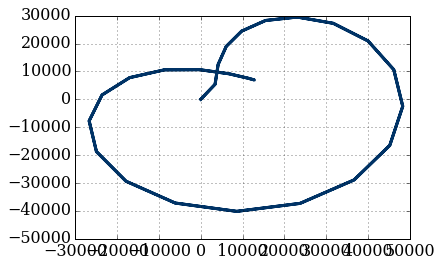

In [78]:
x = numpy.linspace(0,L,nx)

pyplot.plot(psi.imag, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

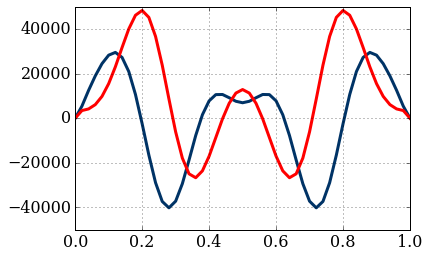

In [79]:
pyplot.plot(x, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)
pyplot.plot(x, psi.imag, color='r', ls='-', lw=3);
pyplot.grid(True)

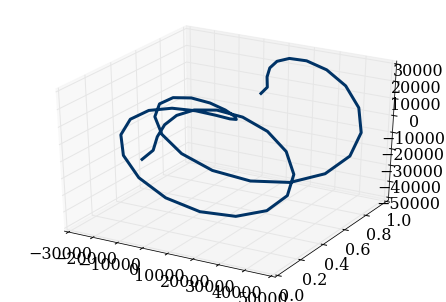

In [80]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init()

ax.plot(psi.imag, x, psi.real, color = '#003366', lw =3)

In [81]:
"""
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

fig = pyplot.figure();
ax = pyplot.axes(xlim = (0,L), ylim = (-5,5))
line, = ax.plot([],[],lw = 2)

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)

display_animation(anim, default_mode = 'once')
"""

"\nfrom matplotlib import animation\nfrom JSAnimation.IPython_display import display_animation\n\nfig = pyplot.figure();\nax = pyplot.axes(xlim = (0,L), ylim = (-5,5))\nline, = ax.plot([],[],lw = 2)\n\ndef animate(data):\n    x = numpy.linspace(0, L, nx)\n    y = data\n    line.set_data(x, y)\n    return line,\n\nanim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)\n\ndisplay_animation(anim, default_mode = 'once')\n"

In [82]:
psi_conj = numpy.conj(psi)
probfunc = psi_conj*psi

#print(psi_conj)
#print()
print(probfunc)
probfunc_real = probfunc.real
#print(probfunc_real)

[  1.00000000e+00+0.j   4.06450858e+07+0.j   1.72745766e+08+0.j
   3.96249851e+08+0.j   6.92504553e+08+0.j   1.03727502e+09+0.j
   1.39988238e+09+0.j   1.74474273e+09+0.j   2.03548973e+09+0.j
   2.24019595e+09+0.j   2.33599122e+09+0.j   2.31283830e+09+0.j
   2.17722106e+09+0.j   1.95472344e+09+0.j   1.68710355e+09+0.j
   1.41959913e+09+0.j   1.18147640e+09+0.j   9.72749125e+08+0.j
   7.71116057e+08+0.j   5.58882095e+08+0.j   3.49353380e+08+0.j
   1.86621911e+08+0.j   1.12887245e+08+0.j   1.28812971e+08+0.j
   1.84225015e+08+0.j   2.12804991e+08+0.j   1.84225015e+08+0.j
   1.28812971e+08+0.j   1.12887245e+08+0.j   1.86621911e+08+0.j
   3.49353380e+08+0.j   5.58882095e+08+0.j   7.71116057e+08+0.j
   9.72749125e+08+0.j   1.18147640e+09+0.j   1.41959913e+09+0.j
   1.68710355e+09+0.j   1.95472344e+09+0.j   2.17722106e+09+0.j
   2.31283830e+09+0.j   2.33599122e+09+0.j   2.24019595e+09+0.j
   2.03548973e+09+0.j   1.74474273e+09+0.j   1.39988238e+09+0.j
   1.03727502e+09+0.j   6.92504553e+08+0

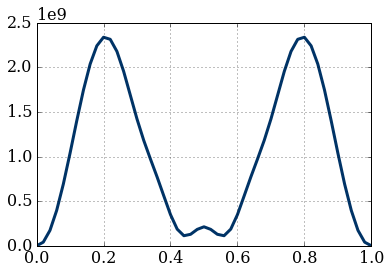

In [83]:
pyplot.plot(x, probfunc_real, color='#003366', ls='-', lw=3);
pyplot.grid(True)


In [84]:
def psi_analytical(x, t, n_max, h, m, L, hbar):
    
    psi = 0
    for n in range (1, n_max+1):
        
        E = ((n**2)*(h**2))/(8*m*(L**2))
        
        summation = numpy.sqrt(2/L)*numpy.sin(n*numpy.pi*x/L)*numpy.exp(-1j*E*t/hbar)
        psi+= summation
        
    return psi


In [85]:
psi_analytical = psi_analytical(x, dt*nt, 1, h, m, L, hbar)
print(psi_analytical)

print(psi_analytical.real)

[  0.00000000e+00 +0.00000000e+00j   8.87948794e-02 -8.76398789e-04j
   1.77239326e-01 -1.74933883e-03j   2.64984290e-01 -2.61537504e-03j
   3.51683482e-01 -3.47108955e-03j   4.36994740e-01 -4.31310525e-03j
   5.20581379e-01 -5.13809911e-03j   6.02113522e-01 -5.94281523e-03j
   6.81269397e-01 -6.72407777e-03j   7.57736614e-01 -7.47880345e-03j
   8.31213390e-01 -8.20401372e-03j   9.01409747e-01 -8.89684648e-03j
   9.68048651e-01 -9.55456746e-03j   1.03086711e+00 -1.01745809e-02j
   1.08961721e+00 -1.07544400e-02j   1.14406708e+00 -1.12918562e-02j
   1.19400185e+00 -1.17847085e-02j   1.23922443e+00 -1.22310521e-02j
   1.27955637e+00 -1.26291252e-02j   1.31483848e+00 -1.29773570e-02j
   1.34493152e+00 -1.32743730e-02j   1.36971673e+00 -1.35190012e-02j
   1.38909629e+00 -1.37102761e-02j   1.40299373e+00 -1.38474427e-02j
   1.41135419e+00 -1.39299599e-02j   1.41414468e+00 -1.39575018e-02j
   1.41135419e+00 -1.39299599e-02j   1.40299373e+00 -1.38474427e-02j
   1.38909629e+00 -1.37102761e-02j

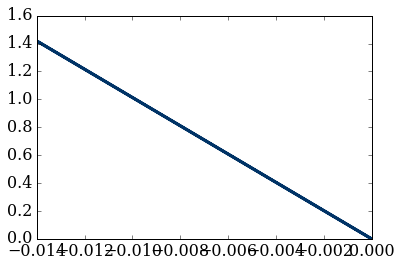

In [86]:
pyplot.plot(psi_analytical.imag, psi_analytical.real, color = '#003366', ls = '-', lw =3)

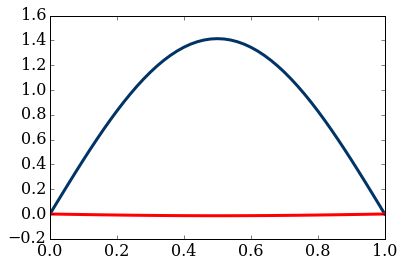

In [87]:
pyplot.plot(x, psi_analytical.real, color = '#003366', ls = '-', lw =3)
pyplot.plot(x, psi_analytical.imag, color = 'r', ls = '-', lw =3)

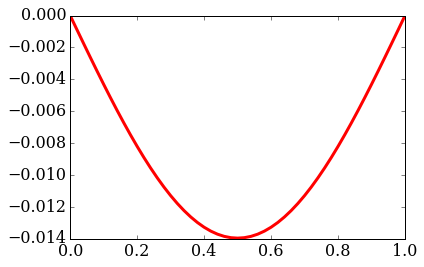

In [88]:
pyplot.plot(x, psi_analytical.imag, color = 'r', ls = '-', lw =3)

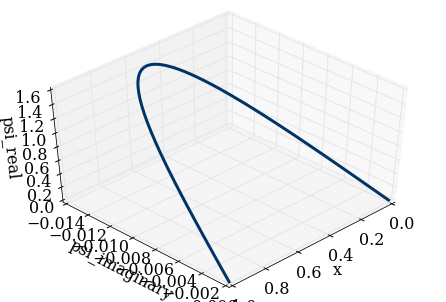

In [89]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.view_init(45,45)

ax.plot(x, psi_analytical.imag, psi_analytical.real, color = '#003366', lw =3)
ax.set_xlabel(r'x')
ax.set_ylabel(r'psi_imaginary')
ax.set_zlabel(r'psi_real')
#ax = pyplot.axes(xlabel=('x'),ylabel=('Real'), zlabel=('Imaginary'));#

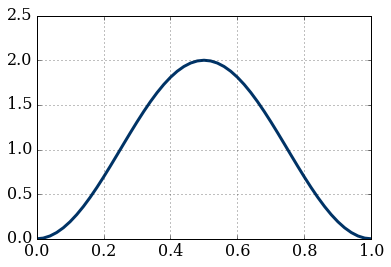

In [90]:
probfunc_analytical = numpy.conj(psi_analytical)*psi_analytical
pyplot.plot(x, probfunc_analytical.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

In [91]:
"""
fig = pylab.figure()
ax = Axes3D(fig)
ax.viewinit()

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)

display_animation(anim, default_mode = 'once')
"""

"\nfig = pylab.figure()\nax = Axes3D(fig)\nax.viewinit()\n\ndef animate(data):\n    x = numpy.linspace(0, L, nx)\n    y = data\n    line.set_data(x, y)\n    return line,\n\nanim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)\n\ndisplay_animation(anim, default_mode = 'once')\n"